In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


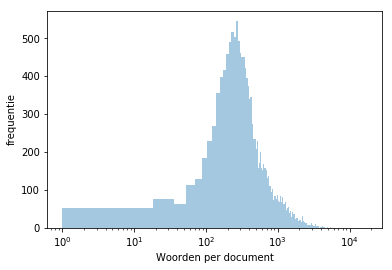

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


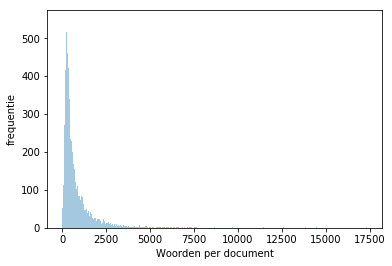

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


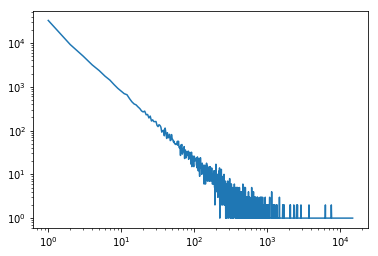

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.13      0.13      0.13      1901
ChristenUnie       0.08      0.08      0.08      1068
         D66       0.13      0.12      0.13      1889
  GroenLinks       0.07      0.07      0.07      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.11      0.12      0.12      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.03      0.04      0.03       655
          SP       0.15      0.16      0.16      2284
         VVD       0.12      0.11      0.12      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    text = df.stemmed_text if text_dict[name] else df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [14]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classification_report_csv(real,predicted):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('     ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1 score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall",'F1 score',"Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [15]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [16]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return [pipe, cnf_matrix, report, accuracy, indices]
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist) /n 
    report=report.round(2)
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

In [17]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:08<00:00, 73.77s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.97    0.81      0.88          79
CDA                0.79    0.79      0.79         392
ChristenUnie       0.84    0.78      0.81         215
D66                0.75    0.72      0.74         378
GroenLinks         0.91    0.69      0.78         210
PVV                0.81    0.87      0.84         342
PvdA               0.68    0.72      0.70         356
PvdD               0.89    0.87      0.88          89
SGP                0.87    0.85      0.86         132
SP                 0.73    0.85      0.78         448
VVD                0.77    0.71      0.74         339
Totaal             0.78    0.78      0.78        2980


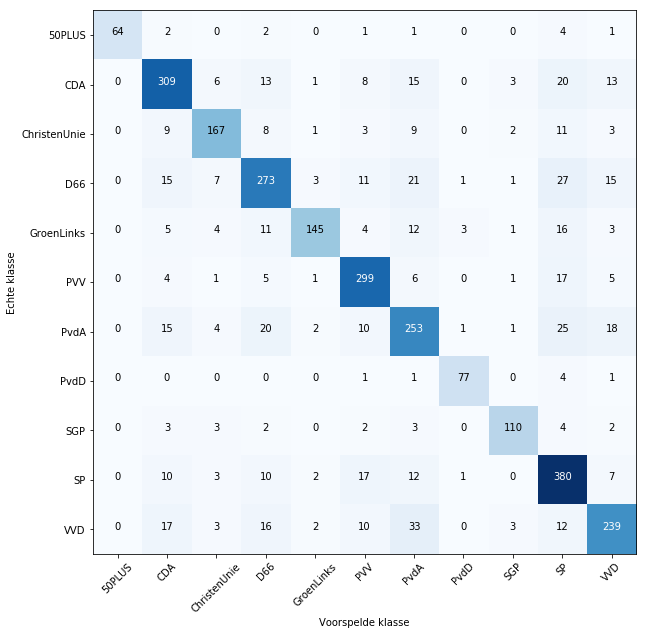

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,het lid ouwehand,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,mijn fractie,lid van tongeren,de pvv,pvda,lid ouwehand naar,de sgp,de sp,vvd
2,het lid krol,cda fractie,het lid dik,leden van veldhoven,lid voortman,klever,van de arbeid,lid ouwehand,sgp fractie,sp fractie,de vvd fractie
3,lid krol,de cda fractie,lid dik,van veldhoven,het lid voortman,islamitische,de arbeid,ouwehand,de leden dijkgraaf,de sp fractie,vvd fractie
4,krol naar mij,de cda,lid dik faber,veldhoven,lid voortman naar,graaf,de partij van,ouwehand naar mij,leden dijkgraaf,lid van gerven,de vvd is
5,krol naar,lid omtzigt naar,dik faber,lid van veldhoven,tongeren,miljard,partij van de,ouwehand naar,de sgp fractie,gerven,vvd is
6,krol,lid omtzigt,faber,lid van meenen,van tongeren,graus,arbeid,dieren,leden van der,van gerven,voor de vvd
7,van 50plus,het lid omtzigt,de leden dik,d66 is,voortman,nederland,partij van,voor de dieren,mevrouw de voorzitter,smaling,wat de vvd
8,gepensioneerden,omtzigt naar mij,leden dik faber,het lid van,tongeren naar mij,lid graus,pvda fractie,thieme,mevrouw de,het lid smaling,de vvd betreft
9,50plus is,omtzigt naar,leden dik,mijn,tongeren naar,het lid graus,de pvda fractie,de dieren,de leden bisschop,lid smaling,vvd betreft


In [18]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="confusionmatrix",params= {'SGD__max_iter':3})
mostimportantwords(pipe, countdf, filename='MostImportantWords')

# What went wrong

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


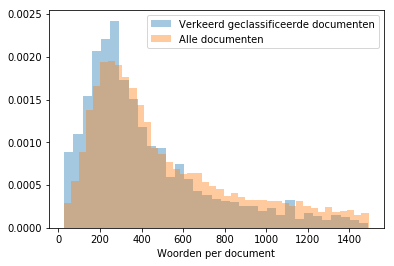

In [19]:
missclassdocs = df.loc[chain.from_iterable(indiceslist)]
np.mean([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
fig, ax = plt.subplots()
for a,l in [(missclassdocs.stemmed_text.apply(lambda x:len(x.split(" "))),'Verkeerd geclassificeerde documenten'), ((df.stemmed_text.apply(lambda x:len(x.split(" ")))),'Alle documenten')]:
    sns.distplot(a, kde=False, norm_hist=True, label=l, axlabel='Woorden per document')
plt.legend()
plt.savefig("Verslag/Tables/misclassifiedlengths.png")
plt.show()

In [20]:
print(len(df[df['titel'].str.contains("Vragen van het lid")])/len(df))
print(len(missclassdocs[missclassdocs['titel'].str.contains("Vragen van het lid")])/len(missclassdocs))

0.045640647023290154
0.07459066100667071


# Without Names

In [21]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:30<00:00, 78.02s/it]


              Precision  Recall  F1 score  Documenten
50PLUS             0.85    0.53      0.65          74
CDA                0.49    0.53      0.51         372
ChristenUnie       0.62    0.44      0.50         206
D66                0.52    0.50      0.51         377
GroenLinks         0.69    0.36      0.48         222
PVV                0.61    0.80      0.69         343
PvdA               0.50    0.49      0.49         364
PvdD               0.74    0.69      0.70          92
SGP                0.66    0.77      0.70         131
SP                 0.57    0.65      0.60         460
VVD                0.51    0.43      0.46         340
Totaal             0.57    0.56      0.55        2980


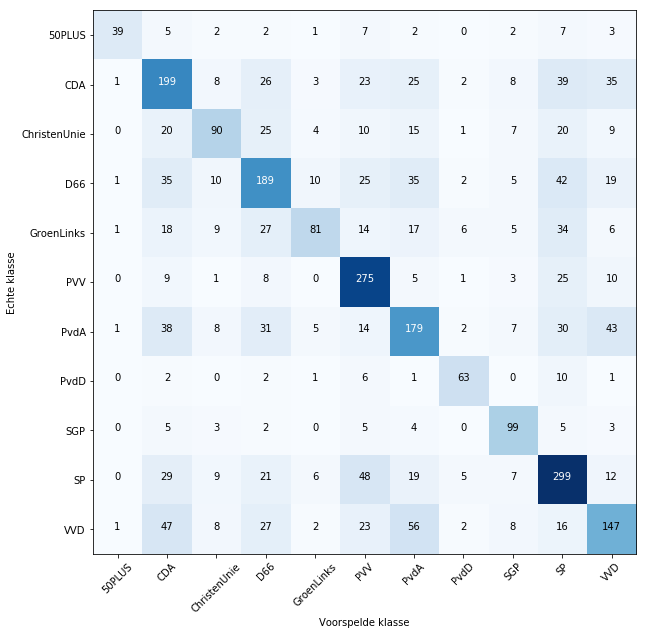

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerden,PARTIJ fractie,vluchtelingen,mijn fractie,zou,islamitische,en,natuur,mevrouw de voorzitter,huurders,PARTIJ
1,ouderen,inwoners,de eurozone,mijn,kamer hierover te,nederland,jongeren,dieren,mevrouw de,mensen,speelveld
2,oudere,PARTIJ,gezinnen,fractie,persoonsgebonden,miljard,circulaire economie,de bio,punt,mening dat,volgens mij
3,koopkrachtontwikkeling,regering,inderdaad,natuurlijk,hierover te informeren,natuurlijk,circulaire,bio,bewindslieden,van mening dat,PARTIJ fractie
4,plussers,hier,eurozone,het kabinet,hierover te,brussel,collega,bio industrie,voor de beantwoording,bezuinigingen,regelgeving
5,50 plussers,de regering,onder,kabinet,persoonsgebonden budget,al,beter,milieu,je,zegt,essentieel
6,50,echt,zullen,belangrijk,schone energie,asielzoekers,wij,industrie,beantwoording,bevolking,aangegeven
7,werkenden,fractie,geestelijke,buitengewoon,vluchtelingen,islam,mijn partij,de bio industrie,de beantwoording,de bevolking,ondernemers
8,overwegende,wij,vraag,vandaag,in elk geval,miljarden,toezeggingen,aarde,de bewindslieden,van mening,aruba
9,overwegende dat,limburg,mensenhandel,minister,elk geval,de islam,kan worden,burgers,nadrukkelijk,voorstellen,evaluatie


In [22]:
pipe, indiceslist = traintest('Scores.xlsx', df, save="withoutnames",params= {'SGD__max_iter':3}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

# Only Names

In [23]:
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen = re.compile('|'.join(partijnamen))
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,stemmed_withoutnames,normal_withoutnames,names
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...,vvd pvda vvd pvv rutte rutte rutte samsom rutte
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...,samsom rutte rutte samsom rutte samsom
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...,d66 pvda d66 d66 rutte samsom
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...,cda cda cda cda cda pechtold samsom wilders
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...,vvd pvda pvda vvd partijvandearbeid samsom samsom


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


              Precision  Recall  F1 score  Documenten
50PLUS             0.88    0.81      0.84          85
CDA                0.61    0.63      0.60         368
ChristenUnie       0.65    0.59      0.61         211
D66                0.56    0.51      0.52         381
GroenLinks         0.69    0.66      0.67         219
PVV                0.69    0.70      0.70         337
PvdA               0.54    0.51      0.52         365
PvdD               0.74    0.75      0.74          82
SGP                0.69    0.47      0.56         130
SP                 0.61    0.64      0.62         454
VVD                0.60    0.57      0.57         348
Totaal             0.63    0.60      0.61        2980


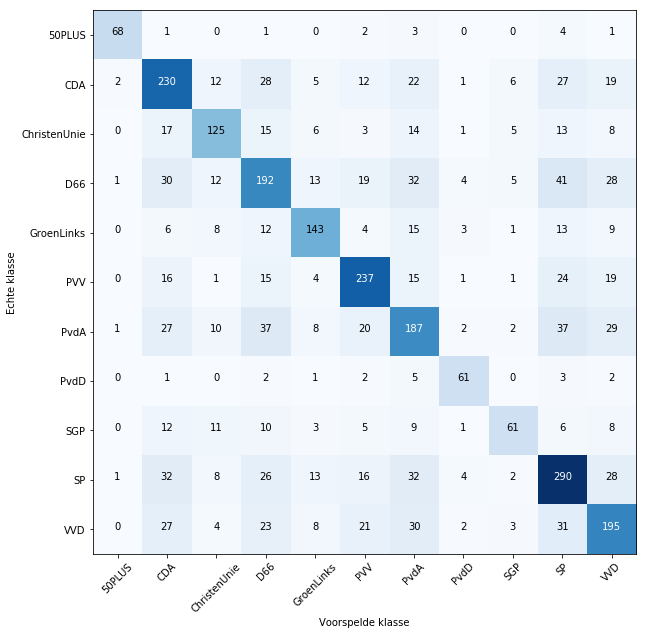

In [24]:
pipe, indiceslist = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1),'SGD__max_iter':3}, stemmed='names', normal='names')

In [25]:
mostimportantwords(pipe, countdf, filename='onlynames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,christenunie,vanmeenen,groenlinks,pvv,partijvandearbeid,partijvoordedieren,sgp,sp,vvd
1,krol,rog,bruins,koşerkaya,voortman,klever,albertdevries,thieme,vanderstaaij,jaspervandijk,aukjedevries
2,timmerman,derouwe,dik,belhaj,vantongeren,tonyvandijck,janvos,ouwehand,bisschop,smaling,rudmerheerema
3,smits,agnesmulder,faber,d66,grashoff,fritsma,cegerek,wassenberg,amhaouch,bashir,remcodijkstra
4,arib,vanhelvert,voordewind,piadijkstra,klaver,partijvoordevrijheid,wolbert,pvdd,houwers,paulusjansen,straus
5,vandijk,geurts,vannieuwenhuizen,vanveldhoven,vanojik,degraaf,jadnanansing,koserkaya,slob,siderius,remcobosma
6,huizing,vanhaersmabuma,slob,bergkamp,ellemeet,madlener,pvda,leegte,bosma,vangerven,venrooy
7,koşerkaya,bruinsslot,segers,hachchi,smits,agema,leenders,groot,geurts,leijten,deliefde
8,klein,ronnes,schouten,sjoerdsma,pia,deroon,meilivos,vanderstaaij,ellemeet,kooiman,deboer
9,bruinsslot,pieterheerma,schouw,koserkaya,teeven,graus,marcouch,madlener,vanhaersmabuma,gesthuizen,welkzijn


# Confusion matrix analyse

In [ ]:
def traintest2(file, data, save=False,params=None,stemmed="stemmed_text",normal="normal_text"):
    train, test = data
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)
    return pipe, oppositie, regering, mix, ggg

In [ ]:
o = []
m = []
r = []
g = {}
for i in tqdm(range(50)):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.xlsx', train_test_split(df, test_size=0.2),params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

In [ ]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='fn + tp')
values = pd.Series(values,name='fp')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

In [ ]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable(o))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(list(chain.from_iterable(m+o+r))))

In [ ]:
scipy.stats.normaltest(list(chain.from_iterable(m+o+r)))

# Woorden Balkenende 4

In [ ]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]

In [ ]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

In [ ]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', dfb4, normal = 'normal_withoutnames', stemmed='stemmed_withoutnames',params= {'SGD__max_iter':100})

In [ ]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

# Vergelijken

In [ ]:
def traintest5(file, data, save=False, stemmed="stemmed_text",normal="normal_text"):
    pipe, stem = getbestpipe(file)
    train, test = data
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    print(report)
    cnf_matrix = confusion_matrix(test.party, predicted)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(train.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())
    return pipe

In [ ]:
pipe = traintest5('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal", stemmed="stemmed_withoutnames", normal="normal_withoutnames")

In [ ]:
pipe = traintest5('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut", stemmed="stemmed_withoutnames", normal="normal_withoutnames")

In [ ]:
woordenBalk = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)
woordenRut = pd.read_excel('MostImportantWordsWithoutNames.xlsx', index_col=0)
commondict = defaultdict(dict)
for partyB in ["PvdA", "ChristenUnie", "CDA"]:
    for partyR in ["VVD", "PvdA"]:
        commondict[partyB][partyR] = [x for x in set(woordenBalk[partyB])&set(woordenRut[partyR]) - set(woordenBalk[partyR]) - set(woordenRut[partyB])]
commondict

In [ ]:
oppositiewoorden = woordenBalk.drop(["PvdA", "ChristenUnie", "CDA"], axis=1).values.flatten()
pointlesswords = ["in","men","de"]
for partyB in ["PvdA","CDA", "ChristenUnie"]:
    for partyR in ["PvdA", "ChristenUnie", "CDA"]:
        if partyR!=partyB:
            for word in woordenBalk[partyR]:
                for word2 in woordenBalk[partyB]:
                    if word in word2 and word not in pointlesswords and word2 not in pointlesswords and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        #print(partyB, "->",partyR,":",word,",", word2)
                        continue

In [ ]:
oppositiewoorden = woordenRut.drop(['VVD', 'PvdA'], axis=1).values.flatten()
for partyB in ["PvdA", "VVD"]:
    for partyR in ["VVD", "PvdA"]:
        if partyR!=partyB:
            for word in woordenRut[partyR]:
                for word2 in woordenRut[partyB]:
                    if word in word2 and word not in ["en","in","men"] and word2 not in ["en","in","men"] and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

# Links / Rechts vergelijken

In [ ]:
# df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
# pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
# pipe, _ = getbestpipe('Scores.xlsx')
# df_train = df.dropna().sample(frac=0.8)
# df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
# df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
# pipe.fit(df_train.withoutnames, df_train.Kieskompas)
# predicted = pipe.predict(df_test.withoutnames)
# print(classification_report(df_test.Kieskompas, predicted))

# Taalgebruik van sprekers

In [26]:
def traintest3(pipe, text, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return pipe, cnf_matrix, report, accuracy, indices
    

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 20%|████████████████▌                                                                  | 1/5 [03:45<15:01, 225.31s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 40%|█████████████████████████████████▏                                                 | 2/5 [07:44<11:37, 232.39s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: Undef

              Precision  Recall  F1 score  Documenten
50PLUS             0.29    0.06      0.09          62
CDA                0.12    0.20      0.14         319
ChristenUnie       0.08    0.14      0.09          74
D66                0.22    0.22      0.22         384
GroenLinks         0.16    0.04      0.05         272
PVV                0.29    0.50      0.37         288
PvdA               0.25    0.19      0.21         422
PvdD               0.46    0.17      0.22         118
SGP                0.17    0.05      0.07          82
SP                 0.34    0.33      0.33         620
VVD                0.31    0.26      0.24         381
Totaal             0.31    0.24      0.24        3023


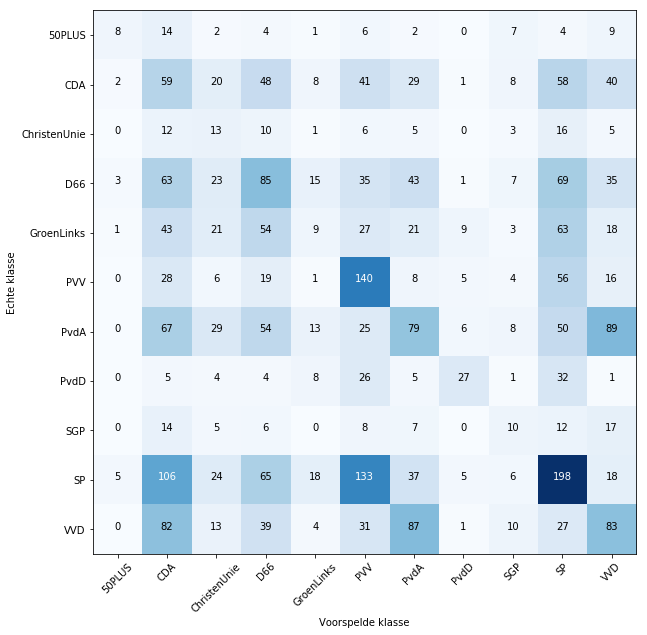

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,ouderen,PARTIJ fractie,mensenhandel,mijn fractie,zou,islamitische,en,dieren,mevrouw de voorzitter,mening dat,PARTIJ
1,gepensioneerden,inwoners,gezinnen,natuurlijk,vluchtelingen,nederland,jongeren,bio industrie,mevrouw de,zegt,PARTIJ fractie
2,koopkrachtontwikkeling,regering,zullen,mijn,kamer hierover te,miljard,daarbij,de bio,beantwoording,van mening dat,aangegeven
3,werkenden,PARTIJ,inderdaad,belangrijk,belastingontwijking,natuurlijk,circulaire economie,bio,voor de beantwoording,mening,volgens mij
4,oudere,fractie,rechtsstaat,buitengewoon,in elk geval,brussel,circulaire,dierenwelzijn,je,segregatie,regelgeving
5,PARTIJ,hier,hoop,fractie,schone energie,islam,die,industrie,de beantwoording,van mening,speelveld
6,overwegende dat,de regering,ik hoop,minister,elk geval,de islam,beter,de bio industrie,punt,personeel,ondernemers
7,overwegende,of,minister president,daarom,in elk,dit kabinet,goede,natuur,wel,huurders,banen
8,mevrouw de voorzitter,diverse,onder,het kabinet,hierover te informeren,al,open standaarden,milieu,bewindslieden,jsf,PARTIJ is
9,mevrouw de,de nederlandse regering,dementie,vandaag,persoonsgebonden,miljarden,economie,constaterende,allerlei,mensen,wellicht


In [27]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="taalgebruik", stemmed='stemmed_withoutnames', normal='normal_withoutnames',params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, 'taalgebruik')